In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [2]:
class Generator(nn.Module):
 
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
    
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):

    return torch.randn(n_samples, input_dim, device=device)

In [3]:
class Discriminator(nn.Module):

    def __init__(self, im_chan=1, hidden_dim=64, c_dim=10):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
        )
        self.d_layer = self.make_disc_block(hidden_dim * 2, 1, final_layer=True)
        self.q_layer = nn.Sequential(
            self.make_disc_block(hidden_dim * 2, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 2 * c_dim, kernel_size=1, final_layer=True)
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        
        intermediate_pred = self.disc(image)
        disc_pred = self.d_layer(intermediate_pred)
        q_pred = self.q_layer(intermediate_pred)
        return disc_pred.view(len(disc_pred), -1), q_pred.view(len(q_pred), -1)

In [4]:
def combine_vectors(x, y):
 
    combined = torch.cat([x.float(), y.float()], 1)
    return combined

In [5]:
from torch.distributions.normal import Normal
adv_criterion = nn.BCEWithLogitsLoss()
c_criterion = lambda c_true, mean, logvar: Normal(mean, logvar.exp()).log_prob(c_true).mean()
c_lambda = 0.1
mnist_shape = (1, 28, 28)
n_epochs = 80
z_dim = 64
c_dim = 2
display_step = 20000
batch_size = 128
# InfoGAN uses two different learning rates for the models
d_lr = 2e-4
g_lr = 1e-3
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [6]:
gen = Generator(input_dim=z_dim + c_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=g_lr)
disc = Discriminator(im_chan=mnist_shape[0], c_dim=c_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=d_lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [7]:
gen.state_dict

<bound method Module.state_dict of Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(66, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)>

In [8]:
disc.state_dict

<bound method Module.state_dict of Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (d_layer): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  )
  (q_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 4, kernel_size=(1, 1), stride=(2, 2))
    )
  )
)>

Epoch 42, step 20000: Generator loss: 3.8786082974016667, discriminator loss: 0.04246960625649954


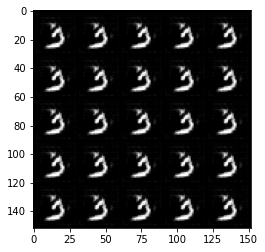

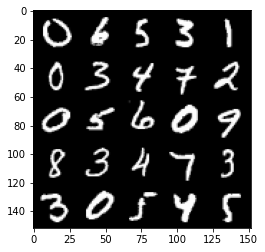

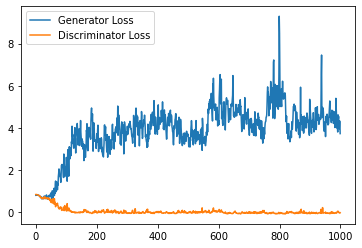

In [9]:
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, _ in (dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        c_labels = get_noise(cur_batch_size, c_dim, device=device)    
        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        # Combine the noise vectors and the one-hot labels for the generator
        noise_and_labels = combine_vectors(fake_noise, c_labels)
        # Generate the conditioned fake images
        fake = gen(noise_and_labels)
        
        # Get the discriminator's predictions
        disc_fake_pred, disc_q_pred = disc(fake.detach())
        disc_q_mean = disc_q_pred[:, :c_dim]
        disc_q_logvar = disc_q_pred[:, c_dim:]
        mutual_information = c_criterion(c_labels, disc_q_mean, disc_q_logvar)
        disc_real_pred, _ = disc(real)
        disc_fake_loss = adv_criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = adv_criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2 - c_lambda * mutual_information
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        disc_fake_pred, disc_q_pred = disc(fake)
        disc_q_mean = disc_q_pred[:, :c_dim]
        disc_q_logvar = disc_q_pred[:, c_dim:]
        mutual_information = c_criterion(c_labels, disc_q_mean, disc_q_logvar)
        gen_loss = adv_criterion(disc_fake_pred, torch.ones_like(disc_fake_pred)) - c_lambda * mutual_information
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1

In [11]:
torch.save(gen.state_dict(), 'gen/gen_1.pth')

In [13]:
torch.save(disc.state_dict(), 'disc/disc_1.pth')

In [14]:
gen = gen.eval()

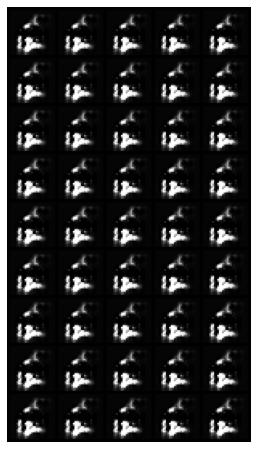

In [15]:
import math

n_interpolation = 9 

def interpolate_class(n_view=5):
    interpolation_noise = get_noise(n_view, z_dim, device=device).repeat(n_interpolation, 1)
    first_label = get_noise(1, c_dim).repeat(n_view, 1)[None, :]
    second_label = first_label.clone()
    first_label[:, :, 0] =  -2
    second_label[:, :, 0] =  2
    

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label
    interpolation_labels = interpolation_labels.view(-1, c_dim)

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation * n_view, nrow=n_view, show=False)

plt.figure(figsize=(8, 8))
interpolate_class()
_ = plt.axis('off')

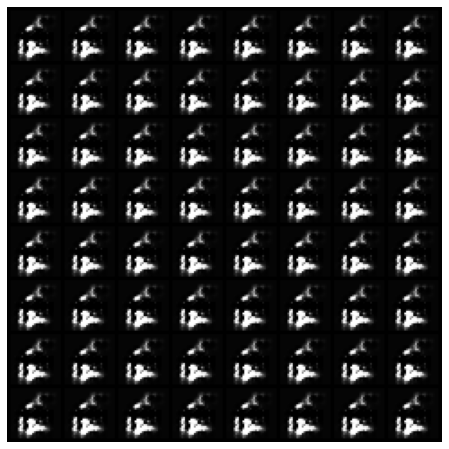

In [17]:
import math

n_interpolation = 8 

def interpolate_class():
    interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation * n_interpolation, 1)
    first_label = get_noise(1, c_dim).repeat(n_interpolation * n_interpolation, 1)
    
    # Calculate the interpolation vector between the two labels
    first_label = torch.linspace(-2, 2, n_interpolation).repeat(n_interpolation)
    second_label = torch.linspace(-2, 2, n_interpolation).repeat_interleave(n_interpolation)
    interpolation_labels = torch.stack([first_label, second_label], dim=1) 

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation * n_interpolation, nrow=n_interpolation, show=False)

plt.figure(figsize=(8, 8))
interpolate_class()
_ = plt.axis('off')
